# 데모

## 라이브러리 import 및 설정

In [24]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [26]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [27]:
data_dir = Path('./input')
feature_dir = Path('./input')
sub_dir = Path('./input')
val_dir = Path('./input')
tst_dir = Path('./input')
trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 10
n_class = 3
seed = 42

In [28]:
algo_name = 'lgb_hyperopt'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [29]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 25)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_zi,d_dered_zr,d_dered_zg,d_dered_zu,d_dered_ir,d_dered_ig,d_dered_iu,d_dered_ru,d_dered_gu,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-0.7232,-2.0462,-3.3488,-6.2153,-1.3230,-2.6257,-5.4921,-4.1691,-2.8665,6.1132
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.1016,-0.2767,-0.8698,-1.8317,-0.1751,-0.7683,-1.7302,-1.5550,-0.9619,1.4427
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.0257,-0.1440,-0.3905,-1.3116,-0.1183,-0.3649,-1.2859,-1.1676,-0.9211,1.8205
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-0.2395,-0.5321,-1.4395,-5.7985,-0.2926,-1.2000,-5.5590,-5.2664,-4.3590,1.8640
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-0.3144,-0.9871,-2.5579,-5.8955,-0.6727,-2.2436,-5.5811,-4.9084,-3.3376,4.5471


In [30]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 24) (80000, 24)


## Hyperparameter Tuning

In [31]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.3, random_state=seed)

In [32]:
params = {
    "objective": "multiclass",
    "n_estimators": 3000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    "num_leaves": hp.choice("num_leaves", [128, 140, 160, 180]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, 1.,0.05),
    "subsample": hp.quniform("subsample", .6, 1., 0.05),
    "min_child_samples": hp.choice('min_child_samples', [85, 100, 125, 150]),
    "max_depth": hp.choice('max_depth', [20,30,50])
                        
}

In [33]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=30,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}
    q
trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=30, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|████████████████████████████████████████████| 30/30 [1:04:28<00:00, 128.93s/trial, best loss: 0.15708534685168107]
{'objective': 'multiclass', 'n_estimators': 3000, 'subsample_freq': 1, 'random_state': 42, 'n_jobs': -1, 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.010041976312041333, 'max_depth': 30, 'min_child_samples': 85, 'num_leaves': 160, 'subsample': 0.8}


## Stratified K-Fold Cross Validation

In [34]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습

In [35]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=20)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.971627
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.957534
[3]	valid_0's multi_logloss: 0.943364
[4]	valid_0's multi_logloss: 0.929913
[5]	valid_0's multi_logloss: 0.917322
[6]	valid_0's multi_logloss: 0.904655
[7]	valid_0's multi_logloss: 0.892925
[8]	valid_0's multi_logloss: 0.880454
[9]	valid_0's multi_logloss: 0.86795
[10]	valid_0's multi_logloss: 0.856217
[11]	valid_0's multi_logloss: 0.845383
[12]	valid_0's multi_logloss: 0.83475
[13]	valid_0's multi_logloss: 0.823964
[14]	valid_0's multi_logloss: 0.813316
[15]	valid_0's multi_logloss: 0.803253
[16]	valid_0's multi_logloss: 0.793277
[17]	valid_0's multi_logloss: 0.783247
[18]	valid_0's multi_logloss: 0.77285
[19]	valid_0's multi_logloss: 0.762955
[20]	valid_0's multi_logloss: 0.753292
[21]	valid_0's multi_logloss: 0.743623
[22]	valid_0's multi_logloss: 0.734046
[23]	valid_0's multi_logloss: 0.72477
[24]	valid_0's multi_logloss: 

[209]	valid_0's multi_logloss: 0.216143
[210]	valid_0's multi_logloss: 0.215489
[211]	valid_0's multi_logloss: 0.215038
[212]	valid_0's multi_logloss: 0.214594
[213]	valid_0's multi_logloss: 0.214053
[214]	valid_0's multi_logloss: 0.213502
[215]	valid_0's multi_logloss: 0.212906
[216]	valid_0's multi_logloss: 0.212235
[217]	valid_0's multi_logloss: 0.211601
[218]	valid_0's multi_logloss: 0.211198
[219]	valid_0's multi_logloss: 0.210544
[220]	valid_0's multi_logloss: 0.209943
[221]	valid_0's multi_logloss: 0.209539
[222]	valid_0's multi_logloss: 0.208984
[223]	valid_0's multi_logloss: 0.208452
[224]	valid_0's multi_logloss: 0.207998
[225]	valid_0's multi_logloss: 0.207465
[226]	valid_0's multi_logloss: 0.206912
[227]	valid_0's multi_logloss: 0.206458
[228]	valid_0's multi_logloss: 0.206019
[229]	valid_0's multi_logloss: 0.205553
[230]	valid_0's multi_logloss: 0.204965
[231]	valid_0's multi_logloss: 0.204473
[232]	valid_0's multi_logloss: 0.204086
[233]	valid_0's multi_logloss: 0.203689


[417]	valid_0's multi_logloss: 0.164698
[418]	valid_0's multi_logloss: 0.164592
[419]	valid_0's multi_logloss: 0.164547
[420]	valid_0's multi_logloss: 0.164436
[421]	valid_0's multi_logloss: 0.164347
[422]	valid_0's multi_logloss: 0.164247
[423]	valid_0's multi_logloss: 0.164177
[424]	valid_0's multi_logloss: 0.164091
[425]	valid_0's multi_logloss: 0.16402
[426]	valid_0's multi_logloss: 0.163931
[427]	valid_0's multi_logloss: 0.163878
[428]	valid_0's multi_logloss: 0.163806
[429]	valid_0's multi_logloss: 0.163704
[430]	valid_0's multi_logloss: 0.163653
[431]	valid_0's multi_logloss: 0.16357
[432]	valid_0's multi_logloss: 0.163501
[433]	valid_0's multi_logloss: 0.163435
[434]	valid_0's multi_logloss: 0.163393
[435]	valid_0's multi_logloss: 0.163314
[436]	valid_0's multi_logloss: 0.163235
[437]	valid_0's multi_logloss: 0.163164
[438]	valid_0's multi_logloss: 0.16308
[439]	valid_0's multi_logloss: 0.163033
[440]	valid_0's multi_logloss: 0.162962
[441]	valid_0's multi_logloss: 0.162911
[44

[624]	valid_0's multi_logloss: 0.15588
[625]	valid_0's multi_logloss: 0.15586
[626]	valid_0's multi_logloss: 0.155837
[627]	valid_0's multi_logloss: 0.155827
[628]	valid_0's multi_logloss: 0.155808
[629]	valid_0's multi_logloss: 0.155779
[630]	valid_0's multi_logloss: 0.155751
[631]	valid_0's multi_logloss: 0.155735
[632]	valid_0's multi_logloss: 0.15571
[633]	valid_0's multi_logloss: 0.155692
[634]	valid_0's multi_logloss: 0.155678
[635]	valid_0's multi_logloss: 0.155656
[636]	valid_0's multi_logloss: 0.155635
[637]	valid_0's multi_logloss: 0.155616
[638]	valid_0's multi_logloss: 0.155597
[639]	valid_0's multi_logloss: 0.155576
[640]	valid_0's multi_logloss: 0.155562
[641]	valid_0's multi_logloss: 0.155547
[642]	valid_0's multi_logloss: 0.155521
[643]	valid_0's multi_logloss: 0.155503
[644]	valid_0's multi_logloss: 0.155487
[645]	valid_0's multi_logloss: 0.155476
[646]	valid_0's multi_logloss: 0.155464
[647]	valid_0's multi_logloss: 0.155443
[648]	valid_0's multi_logloss: 0.155412
[64

[830]	valid_0's multi_logloss: 0.153413
[831]	valid_0's multi_logloss: 0.153412
[832]	valid_0's multi_logloss: 0.153404
[833]	valid_0's multi_logloss: 0.153398
[834]	valid_0's multi_logloss: 0.153392
[835]	valid_0's multi_logloss: 0.153391
[836]	valid_0's multi_logloss: 0.153388
[837]	valid_0's multi_logloss: 0.153382
[838]	valid_0's multi_logloss: 0.153373
[839]	valid_0's multi_logloss: 0.153358
[840]	valid_0's multi_logloss: 0.153352
[841]	valid_0's multi_logloss: 0.153344
[842]	valid_0's multi_logloss: 0.15333
[843]	valid_0's multi_logloss: 0.153325
[844]	valid_0's multi_logloss: 0.153323
[845]	valid_0's multi_logloss: 0.153313
[846]	valid_0's multi_logloss: 0.153311
[847]	valid_0's multi_logloss: 0.153304
[848]	valid_0's multi_logloss: 0.153294
[849]	valid_0's multi_logloss: 0.153287
[850]	valid_0's multi_logloss: 0.153278
[851]	valid_0's multi_logloss: 0.15327
[852]	valid_0's multi_logloss: 0.153261
[853]	valid_0's multi_logloss: 0.153258
[854]	valid_0's multi_logloss: 0.15325
[85

[1037]	valid_0's multi_logloss: 0.152603
[1038]	valid_0's multi_logloss: 0.152605
[1039]	valid_0's multi_logloss: 0.152607
[1040]	valid_0's multi_logloss: 0.152605
[1041]	valid_0's multi_logloss: 0.152606
[1042]	valid_0's multi_logloss: 0.152606
[1043]	valid_0's multi_logloss: 0.152611
[1044]	valid_0's multi_logloss: 0.152607
[1045]	valid_0's multi_logloss: 0.152605
[1046]	valid_0's multi_logloss: 0.152602
[1047]	valid_0's multi_logloss: 0.152597
[1048]	valid_0's multi_logloss: 0.152593
[1049]	valid_0's multi_logloss: 0.152594
[1050]	valid_0's multi_logloss: 0.152596
[1051]	valid_0's multi_logloss: 0.152594
[1052]	valid_0's multi_logloss: 0.152591
[1053]	valid_0's multi_logloss: 0.15258
[1054]	valid_0's multi_logloss: 0.152586
[1055]	valid_0's multi_logloss: 0.152586
[1056]	valid_0's multi_logloss: 0.152581
[1057]	valid_0's multi_logloss: 0.152581
[1058]	valid_0's multi_logloss: 0.152583
[1059]	valid_0's multi_logloss: 0.152573
[1060]	valid_0's multi_logloss: 0.152567
[1061]	valid_0's 

[73]	valid_0's multi_logloss: 0.442271
[74]	valid_0's multi_logloss: 0.438701
[75]	valid_0's multi_logloss: 0.435318
[76]	valid_0's multi_logloss: 0.431506
[77]	valid_0's multi_logloss: 0.42794
[78]	valid_0's multi_logloss: 0.424584
[79]	valid_0's multi_logloss: 0.421635
[80]	valid_0's multi_logloss: 0.418532
[81]	valid_0's multi_logloss: 0.415357
[82]	valid_0's multi_logloss: 0.412246
[83]	valid_0's multi_logloss: 0.409075
[84]	valid_0's multi_logloss: 0.405809
[85]	valid_0's multi_logloss: 0.402551
[86]	valid_0's multi_logloss: 0.399527
[87]	valid_0's multi_logloss: 0.396474
[88]	valid_0's multi_logloss: 0.393273
[89]	valid_0's multi_logloss: 0.390332
[90]	valid_0's multi_logloss: 0.387472
[91]	valid_0's multi_logloss: 0.384654
[92]	valid_0's multi_logloss: 0.381759
[93]	valid_0's multi_logloss: 0.379141
[94]	valid_0's multi_logloss: 0.376423
[95]	valid_0's multi_logloss: 0.374014
[96]	valid_0's multi_logloss: 0.371418
[97]	valid_0's multi_logloss: 0.369161
[98]	valid_0's multi_loglo

[282]	valid_0's multi_logloss: 0.187809
[283]	valid_0's multi_logloss: 0.187449
[284]	valid_0's multi_logloss: 0.187199
[285]	valid_0's multi_logloss: 0.186886
[286]	valid_0's multi_logloss: 0.186566
[287]	valid_0's multi_logloss: 0.186357
[288]	valid_0's multi_logloss: 0.186104
[289]	valid_0's multi_logloss: 0.185841
[290]	valid_0's multi_logloss: 0.185571
[291]	valid_0's multi_logloss: 0.1853
[292]	valid_0's multi_logloss: 0.185008
[293]	valid_0's multi_logloss: 0.184763
[294]	valid_0's multi_logloss: 0.184585
[295]	valid_0's multi_logloss: 0.1843
[296]	valid_0's multi_logloss: 0.184032
[297]	valid_0's multi_logloss: 0.183797
[298]	valid_0's multi_logloss: 0.183502
[299]	valid_0's multi_logloss: 0.183229
[300]	valid_0's multi_logloss: 0.183029
[301]	valid_0's multi_logloss: 0.182862
[302]	valid_0's multi_logloss: 0.182635
[303]	valid_0's multi_logloss: 0.182376
[304]	valid_0's multi_logloss: 0.182171
[305]	valid_0's multi_logloss: 0.181994
[306]	valid_0's multi_logloss: 0.18178
[307]

[488]	valid_0's multi_logloss: 0.161487
[489]	valid_0's multi_logloss: 0.161429
[490]	valid_0's multi_logloss: 0.161388
[491]	valid_0's multi_logloss: 0.161325
[492]	valid_0's multi_logloss: 0.161272
[493]	valid_0's multi_logloss: 0.161246
[494]	valid_0's multi_logloss: 0.161205
[495]	valid_0's multi_logloss: 0.161182
[496]	valid_0's multi_logloss: 0.161138
[497]	valid_0's multi_logloss: 0.161101
[498]	valid_0's multi_logloss: 0.16106
[499]	valid_0's multi_logloss: 0.161024
[500]	valid_0's multi_logloss: 0.160978
[501]	valid_0's multi_logloss: 0.16094
[502]	valid_0's multi_logloss: 0.16091
[503]	valid_0's multi_logloss: 0.160867
[504]	valid_0's multi_logloss: 0.160828
[505]	valid_0's multi_logloss: 0.160794
[506]	valid_0's multi_logloss: 0.16076
[507]	valid_0's multi_logloss: 0.160722
[508]	valid_0's multi_logloss: 0.160675
[509]	valid_0's multi_logloss: 0.160613
[510]	valid_0's multi_logloss: 0.160565
[511]	valid_0's multi_logloss: 0.16051
[512]	valid_0's multi_logloss: 0.160487
[513]

[697]	valid_0's multi_logloss: 0.156127
[698]	valid_0's multi_logloss: 0.156122
[699]	valid_0's multi_logloss: 0.156104
[700]	valid_0's multi_logloss: 0.156083
[701]	valid_0's multi_logloss: 0.156071
[702]	valid_0's multi_logloss: 0.156052
[703]	valid_0's multi_logloss: 0.156047
[704]	valid_0's multi_logloss: 0.156036
[705]	valid_0's multi_logloss: 0.156019
[706]	valid_0's multi_logloss: 0.156011
[707]	valid_0's multi_logloss: 0.155992
[708]	valid_0's multi_logloss: 0.155975
[709]	valid_0's multi_logloss: 0.155966
[710]	valid_0's multi_logloss: 0.155958
[711]	valid_0's multi_logloss: 0.155947
[712]	valid_0's multi_logloss: 0.155933
[713]	valid_0's multi_logloss: 0.155919
[714]	valid_0's multi_logloss: 0.155906
[715]	valid_0's multi_logloss: 0.155902
[716]	valid_0's multi_logloss: 0.155894
[717]	valid_0's multi_logloss: 0.155881
[718]	valid_0's multi_logloss: 0.155867
[719]	valid_0's multi_logloss: 0.155854
[720]	valid_0's multi_logloss: 0.155848
[721]	valid_0's multi_logloss: 0.155842


[904]	valid_0's multi_logloss: 0.154545
[905]	valid_0's multi_logloss: 0.154545
[906]	valid_0's multi_logloss: 0.154539
[907]	valid_0's multi_logloss: 0.154531
[908]	valid_0's multi_logloss: 0.154527
[909]	valid_0's multi_logloss: 0.154517
[910]	valid_0's multi_logloss: 0.154515
[911]	valid_0's multi_logloss: 0.154511
[912]	valid_0's multi_logloss: 0.154511
[913]	valid_0's multi_logloss: 0.15451
[914]	valid_0's multi_logloss: 0.154506
[915]	valid_0's multi_logloss: 0.154505
[916]	valid_0's multi_logloss: 0.154497
[917]	valid_0's multi_logloss: 0.154488
[918]	valid_0's multi_logloss: 0.154479
[919]	valid_0's multi_logloss: 0.154476
[920]	valid_0's multi_logloss: 0.154471
[921]	valid_0's multi_logloss: 0.154468
[922]	valid_0's multi_logloss: 0.154459
[923]	valid_0's multi_logloss: 0.154452
[924]	valid_0's multi_logloss: 0.154447
[925]	valid_0's multi_logloss: 0.15444
[926]	valid_0's multi_logloss: 0.154437
[927]	valid_0's multi_logloss: 0.154432
[928]	valid_0's multi_logloss: 0.154431
[9

[1108]	valid_0's multi_logloss: 0.154136
[1109]	valid_0's multi_logloss: 0.154136
[1110]	valid_0's multi_logloss: 0.154133
[1111]	valid_0's multi_logloss: 0.154125
[1112]	valid_0's multi_logloss: 0.154125
[1113]	valid_0's multi_logloss: 0.154119
[1114]	valid_0's multi_logloss: 0.154115
[1115]	valid_0's multi_logloss: 0.154118
[1116]	valid_0's multi_logloss: 0.154115
[1117]	valid_0's multi_logloss: 0.154111
[1118]	valid_0's multi_logloss: 0.154111
[1119]	valid_0's multi_logloss: 0.154107
[1120]	valid_0's multi_logloss: 0.15411
[1121]	valid_0's multi_logloss: 0.154109
[1122]	valid_0's multi_logloss: 0.154103
[1123]	valid_0's multi_logloss: 0.154104
[1124]	valid_0's multi_logloss: 0.154107
[1125]	valid_0's multi_logloss: 0.154101
[1126]	valid_0's multi_logloss: 0.154099
[1127]	valid_0's multi_logloss: 0.154102
[1128]	valid_0's multi_logloss: 0.154109
[1129]	valid_0's multi_logloss: 0.154108
[1130]	valid_0's multi_logloss: 0.154107
[1131]	valid_0's multi_logloss: 0.154104
[1132]	valid_0's 

[112]	valid_0's multi_logloss: 0.33163
[113]	valid_0's multi_logloss: 0.329371
[114]	valid_0's multi_logloss: 0.327444
[115]	valid_0's multi_logloss: 0.325298
[116]	valid_0's multi_logloss: 0.32331
[117]	valid_0's multi_logloss: 0.321348
[118]	valid_0's multi_logloss: 0.31968
[119]	valid_0's multi_logloss: 0.317801
[120]	valid_0's multi_logloss: 0.315931
[121]	valid_0's multi_logloss: 0.314241
[122]	valid_0's multi_logloss: 0.312246
[123]	valid_0's multi_logloss: 0.310585
[124]	valid_0's multi_logloss: 0.308906
[125]	valid_0's multi_logloss: 0.307305
[126]	valid_0's multi_logloss: 0.305459
[127]	valid_0's multi_logloss: 0.303596
[128]	valid_0's multi_logloss: 0.302051
[129]	valid_0's multi_logloss: 0.300308
[130]	valid_0's multi_logloss: 0.298655
[131]	valid_0's multi_logloss: 0.296863
[132]	valid_0's multi_logloss: 0.29512
[133]	valid_0's multi_logloss: 0.293595
[134]	valid_0's multi_logloss: 0.292111
[135]	valid_0's multi_logloss: 0.290369
[136]	valid_0's multi_logloss: 0.288725
[137

[321]	valid_0's multi_logloss: 0.176135
[322]	valid_0's multi_logloss: 0.17589
[323]	valid_0's multi_logloss: 0.175737
[324]	valid_0's multi_logloss: 0.175564
[325]	valid_0's multi_logloss: 0.175382
[326]	valid_0's multi_logloss: 0.175163
[327]	valid_0's multi_logloss: 0.174947
[328]	valid_0's multi_logloss: 0.174726
[329]	valid_0's multi_logloss: 0.174553
[330]	valid_0's multi_logloss: 0.174452
[331]	valid_0's multi_logloss: 0.17426
[332]	valid_0's multi_logloss: 0.17407
[333]	valid_0's multi_logloss: 0.173871
[334]	valid_0's multi_logloss: 0.173725
[335]	valid_0's multi_logloss: 0.173608
[336]	valid_0's multi_logloss: 0.173439
[337]	valid_0's multi_logloss: 0.173303
[338]	valid_0's multi_logloss: 0.173122
[339]	valid_0's multi_logloss: 0.172996
[340]	valid_0's multi_logloss: 0.172878
[341]	valid_0's multi_logloss: 0.172718
[342]	valid_0's multi_logloss: 0.172535
[343]	valid_0's multi_logloss: 0.172348
[344]	valid_0's multi_logloss: 0.172202
[345]	valid_0's multi_logloss: 0.172007
[34

[528]	valid_0's multi_logloss: 0.157325
[529]	valid_0's multi_logloss: 0.157289
[530]	valid_0's multi_logloss: 0.157244
[531]	valid_0's multi_logloss: 0.157206
[532]	valid_0's multi_logloss: 0.15717
[533]	valid_0's multi_logloss: 0.157129
[534]	valid_0's multi_logloss: 0.157098
[535]	valid_0's multi_logloss: 0.157056
[536]	valid_0's multi_logloss: 0.157035
[537]	valid_0's multi_logloss: 0.157005
[538]	valid_0's multi_logloss: 0.156986
[539]	valid_0's multi_logloss: 0.156947
[540]	valid_0's multi_logloss: 0.156921
[541]	valid_0's multi_logloss: 0.156895
[542]	valid_0's multi_logloss: 0.156863
[543]	valid_0's multi_logloss: 0.156827
[544]	valid_0's multi_logloss: 0.156773
[545]	valid_0's multi_logloss: 0.156754
[546]	valid_0's multi_logloss: 0.156731
[547]	valid_0's multi_logloss: 0.156693
[548]	valid_0's multi_logloss: 0.156671
[549]	valid_0's multi_logloss: 0.156635
[550]	valid_0's multi_logloss: 0.156613
[551]	valid_0's multi_logloss: 0.15657
[552]	valid_0's multi_logloss: 0.156534
[5

[733]	valid_0's multi_logloss: 0.153231
[734]	valid_0's multi_logloss: 0.153221
[735]	valid_0's multi_logloss: 0.153208
[736]	valid_0's multi_logloss: 0.1532
[737]	valid_0's multi_logloss: 0.153191
[738]	valid_0's multi_logloss: 0.153186
[739]	valid_0's multi_logloss: 0.153174
[740]	valid_0's multi_logloss: 0.153163
[741]	valid_0's multi_logloss: 0.153143
[742]	valid_0's multi_logloss: 0.153135
[743]	valid_0's multi_logloss: 0.153119
[744]	valid_0's multi_logloss: 0.153108
[745]	valid_0's multi_logloss: 0.153102
[746]	valid_0's multi_logloss: 0.153085
[747]	valid_0's multi_logloss: 0.153071
[748]	valid_0's multi_logloss: 0.153062
[749]	valid_0's multi_logloss: 0.153047
[750]	valid_0's multi_logloss: 0.153035
[751]	valid_0's multi_logloss: 0.153019
[752]	valid_0's multi_logloss: 0.153005
[753]	valid_0's multi_logloss: 0.153001
[754]	valid_0's multi_logloss: 0.152993
[755]	valid_0's multi_logloss: 0.152986
[756]	valid_0's multi_logloss: 0.152978
[757]	valid_0's multi_logloss: 0.15297
[75

[943]	valid_0's multi_logloss: 0.151949
[944]	valid_0's multi_logloss: 0.15195
[945]	valid_0's multi_logloss: 0.151946
[946]	valid_0's multi_logloss: 0.151944
[947]	valid_0's multi_logloss: 0.151938
[948]	valid_0's multi_logloss: 0.151937
[949]	valid_0's multi_logloss: 0.151929
[950]	valid_0's multi_logloss: 0.151928
[951]	valid_0's multi_logloss: 0.151925
[952]	valid_0's multi_logloss: 0.151925
[953]	valid_0's multi_logloss: 0.151919
[954]	valid_0's multi_logloss: 0.151915
[955]	valid_0's multi_logloss: 0.151906
[956]	valid_0's multi_logloss: 0.151903
[957]	valid_0's multi_logloss: 0.151906
[958]	valid_0's multi_logloss: 0.1519
[959]	valid_0's multi_logloss: 0.151901
[960]	valid_0's multi_logloss: 0.1519
[961]	valid_0's multi_logloss: 0.151898
[962]	valid_0's multi_logloss: 0.151891
[963]	valid_0's multi_logloss: 0.15189
[964]	valid_0's multi_logloss: 0.151886
[965]	valid_0's multi_logloss: 0.151884
[966]	valid_0's multi_logloss: 0.151872
[967]	valid_0's multi_logloss: 0.151868
[968]	

[1147]	valid_0's multi_logloss: 0.151529
[1148]	valid_0's multi_logloss: 0.151526
[1149]	valid_0's multi_logloss: 0.151529
[1150]	valid_0's multi_logloss: 0.151529
[1151]	valid_0's multi_logloss: 0.151528
[1152]	valid_0's multi_logloss: 0.151526
[1153]	valid_0's multi_logloss: 0.151524
[1154]	valid_0's multi_logloss: 0.151527
[1155]	valid_0's multi_logloss: 0.151524
[1156]	valid_0's multi_logloss: 0.151527
[1157]	valid_0's multi_logloss: 0.151525
[1158]	valid_0's multi_logloss: 0.151522
[1159]	valid_0's multi_logloss: 0.151522
[1160]	valid_0's multi_logloss: 0.151524
[1161]	valid_0's multi_logloss: 0.151526
[1162]	valid_0's multi_logloss: 0.151522
[1163]	valid_0's multi_logloss: 0.151518
[1164]	valid_0's multi_logloss: 0.151517
[1165]	valid_0's multi_logloss: 0.151524
[1166]	valid_0's multi_logloss: 0.151528
[1167]	valid_0's multi_logloss: 0.151523
[1168]	valid_0's multi_logloss: 0.151521
[1169]	valid_0's multi_logloss: 0.151522
[1170]	valid_0's multi_logloss: 0.151525
[1171]	valid_0's

[132]	valid_0's multi_logloss: 0.300585
[133]	valid_0's multi_logloss: 0.299078
[134]	valid_0's multi_logloss: 0.297606
[135]	valid_0's multi_logloss: 0.295874
[136]	valid_0's multi_logloss: 0.294212
[137]	valid_0's multi_logloss: 0.292538
[138]	valid_0's multi_logloss: 0.290891
[139]	valid_0's multi_logloss: 0.289403
[140]	valid_0's multi_logloss: 0.287805
[141]	valid_0's multi_logloss: 0.286526
[142]	valid_0's multi_logloss: 0.285154
[143]	valid_0's multi_logloss: 0.283792
[144]	valid_0's multi_logloss: 0.282297
[145]	valid_0's multi_logloss: 0.280819
[146]	valid_0's multi_logloss: 0.279326
[147]	valid_0's multi_logloss: 0.277891
[148]	valid_0's multi_logloss: 0.276513
[149]	valid_0's multi_logloss: 0.275084
[150]	valid_0's multi_logloss: 0.273776
[151]	valid_0's multi_logloss: 0.272622
[152]	valid_0's multi_logloss: 0.271422
[153]	valid_0's multi_logloss: 0.270287
[154]	valid_0's multi_logloss: 0.269035
[155]	valid_0's multi_logloss: 0.268093
[156]	valid_0's multi_logloss: 0.266871


[339]	valid_0's multi_logloss: 0.179183
[340]	valid_0's multi_logloss: 0.179065
[341]	valid_0's multi_logloss: 0.178911
[342]	valid_0's multi_logloss: 0.178727
[343]	valid_0's multi_logloss: 0.178547
[344]	valid_0's multi_logloss: 0.178411
[345]	valid_0's multi_logloss: 0.178224
[346]	valid_0's multi_logloss: 0.178082
[347]	valid_0's multi_logloss: 0.177893
[348]	valid_0's multi_logloss: 0.177742
[349]	valid_0's multi_logloss: 0.177623
[350]	valid_0's multi_logloss: 0.177497
[351]	valid_0's multi_logloss: 0.177392
[352]	valid_0's multi_logloss: 0.1772
[353]	valid_0's multi_logloss: 0.177045
[354]	valid_0's multi_logloss: 0.176854
[355]	valid_0's multi_logloss: 0.176705
[356]	valid_0's multi_logloss: 0.176524
[357]	valid_0's multi_logloss: 0.176411
[358]	valid_0's multi_logloss: 0.176268
[359]	valid_0's multi_logloss: 0.176101
[360]	valid_0's multi_logloss: 0.176002
[361]	valid_0's multi_logloss: 0.175839
[362]	valid_0's multi_logloss: 0.175673
[363]	valid_0's multi_logloss: 0.175543
[3

[544]	valid_0's multi_logloss: 0.162649
[545]	valid_0's multi_logloss: 0.162629
[546]	valid_0's multi_logloss: 0.162601
[547]	valid_0's multi_logloss: 0.162561
[548]	valid_0's multi_logloss: 0.162529
[549]	valid_0's multi_logloss: 0.162499
[550]	valid_0's multi_logloss: 0.162479
[551]	valid_0's multi_logloss: 0.16244
[552]	valid_0's multi_logloss: 0.162406
[553]	valid_0's multi_logloss: 0.162369
[554]	valid_0's multi_logloss: 0.162348
[555]	valid_0's multi_logloss: 0.162315
[556]	valid_0's multi_logloss: 0.162289
[557]	valid_0's multi_logloss: 0.162258
[558]	valid_0's multi_logloss: 0.16222
[559]	valid_0's multi_logloss: 0.162201
[560]	valid_0's multi_logloss: 0.162164
[561]	valid_0's multi_logloss: 0.162144
[562]	valid_0's multi_logloss: 0.162106
[563]	valid_0's multi_logloss: 0.162082
[564]	valid_0's multi_logloss: 0.162058
[565]	valid_0's multi_logloss: 0.162036
[566]	valid_0's multi_logloss: 0.162006
[567]	valid_0's multi_logloss: 0.161991
[568]	valid_0's multi_logloss: 0.161962
[5

[751]	valid_0's multi_logloss: 0.158654
[752]	valid_0's multi_logloss: 0.158645
[753]	valid_0's multi_logloss: 0.15864
[754]	valid_0's multi_logloss: 0.158625
[755]	valid_0's multi_logloss: 0.15862
[756]	valid_0's multi_logloss: 0.158614
[757]	valid_0's multi_logloss: 0.1586
[758]	valid_0's multi_logloss: 0.158583
[759]	valid_0's multi_logloss: 0.158569
[760]	valid_0's multi_logloss: 0.158561
[761]	valid_0's multi_logloss: 0.15855
[762]	valid_0's multi_logloss: 0.158544
[763]	valid_0's multi_logloss: 0.158535
[764]	valid_0's multi_logloss: 0.158529
[765]	valid_0's multi_logloss: 0.158522
[766]	valid_0's multi_logloss: 0.158503
[767]	valid_0's multi_logloss: 0.158497
[768]	valid_0's multi_logloss: 0.158486
[769]	valid_0's multi_logloss: 0.158475
[770]	valid_0's multi_logloss: 0.158465
[771]	valid_0's multi_logloss: 0.158461
[772]	valid_0's multi_logloss: 0.158455
[773]	valid_0's multi_logloss: 0.158445
[774]	valid_0's multi_logloss: 0.158438
[775]	valid_0's multi_logloss: 0.158431
[776]

[959]	valid_0's multi_logloss: 0.157431
[960]	valid_0's multi_logloss: 0.157429
[961]	valid_0's multi_logloss: 0.157432
[962]	valid_0's multi_logloss: 0.157422
[963]	valid_0's multi_logloss: 0.157417
[964]	valid_0's multi_logloss: 0.157412
[965]	valid_0's multi_logloss: 0.157407
[966]	valid_0's multi_logloss: 0.157396
[967]	valid_0's multi_logloss: 0.15739
[968]	valid_0's multi_logloss: 0.15739
[969]	valid_0's multi_logloss: 0.157381
[970]	valid_0's multi_logloss: 0.157376
[971]	valid_0's multi_logloss: 0.157369
[972]	valid_0's multi_logloss: 0.157369
[973]	valid_0's multi_logloss: 0.157365
[974]	valid_0's multi_logloss: 0.157367
[975]	valid_0's multi_logloss: 0.157359
[976]	valid_0's multi_logloss: 0.157358
[977]	valid_0's multi_logloss: 0.157357
[978]	valid_0's multi_logloss: 0.15735
[979]	valid_0's multi_logloss: 0.157351
[980]	valid_0's multi_logloss: 0.157348
[981]	valid_0's multi_logloss: 0.157345
[982]	valid_0's multi_logloss: 0.157337
[983]	valid_0's multi_logloss: 0.157334
[98

[1160]	valid_0's multi_logloss: 0.157107
[1161]	valid_0's multi_logloss: 0.157106
[1162]	valid_0's multi_logloss: 0.157102
[1163]	valid_0's multi_logloss: 0.1571
[1164]	valid_0's multi_logloss: 0.157092
[1165]	valid_0's multi_logloss: 0.157089
[1166]	valid_0's multi_logloss: 0.157085
[1167]	valid_0's multi_logloss: 0.157085
[1168]	valid_0's multi_logloss: 0.157086
[1169]	valid_0's multi_logloss: 0.157089
[1170]	valid_0's multi_logloss: 0.157092
[1171]	valid_0's multi_logloss: 0.157089
[1172]	valid_0's multi_logloss: 0.157085
[1173]	valid_0's multi_logloss: 0.157086
[1174]	valid_0's multi_logloss: 0.157086
[1175]	valid_0's multi_logloss: 0.157088
[1176]	valid_0's multi_logloss: 0.157092
[1177]	valid_0's multi_logloss: 0.157097
[1178]	valid_0's multi_logloss: 0.157096
[1179]	valid_0's multi_logloss: 0.157101
[1180]	valid_0's multi_logloss: 0.157102
[1181]	valid_0's multi_logloss: 0.157099
[1182]	valid_0's multi_logloss: 0.157093
[1183]	valid_0's multi_logloss: 0.157094
[1184]	valid_0's m

[178]	valid_0's multi_logloss: 0.239866
[179]	valid_0's multi_logloss: 0.238908
[180]	valid_0's multi_logloss: 0.23802
[181]	valid_0's multi_logloss: 0.237306
[182]	valid_0's multi_logloss: 0.236429
[183]	valid_0's multi_logloss: 0.235531
[184]	valid_0's multi_logloss: 0.234567
[185]	valid_0's multi_logloss: 0.233647
[186]	valid_0's multi_logloss: 0.23273
[187]	valid_0's multi_logloss: 0.231849
[188]	valid_0's multi_logloss: 0.231112
[189]	valid_0's multi_logloss: 0.23035
[190]	valid_0's multi_logloss: 0.22961
[191]	valid_0's multi_logloss: 0.228719
[192]	valid_0's multi_logloss: 0.227979
[193]	valid_0's multi_logloss: 0.227273
[194]	valid_0's multi_logloss: 0.226611
[195]	valid_0's multi_logloss: 0.225937
[196]	valid_0's multi_logloss: 0.225265
[197]	valid_0's multi_logloss: 0.22446
[198]	valid_0's multi_logloss: 0.223862
[199]	valid_0's multi_logloss: 0.22311
[200]	valid_0's multi_logloss: 0.22242
[201]	valid_0's multi_logloss: 0.221754
[202]	valid_0's multi_logloss: 0.221024
[203]	v

[384]	valid_0's multi_logloss: 0.168035
[385]	valid_0's multi_logloss: 0.16796
[386]	valid_0's multi_logloss: 0.167837
[387]	valid_0's multi_logloss: 0.167724
[388]	valid_0's multi_logloss: 0.167636
[389]	valid_0's multi_logloss: 0.167509
[390]	valid_0's multi_logloss: 0.16744
[391]	valid_0's multi_logloss: 0.167313
[392]	valid_0's multi_logloss: 0.167202
[393]	valid_0's multi_logloss: 0.167098
[394]	valid_0's multi_logloss: 0.167007
[395]	valid_0's multi_logloss: 0.166937
[396]	valid_0's multi_logloss: 0.166835
[397]	valid_0's multi_logloss: 0.166744
[398]	valid_0's multi_logloss: 0.166668
[399]	valid_0's multi_logloss: 0.166568
[400]	valid_0's multi_logloss: 0.16646
[401]	valid_0's multi_logloss: 0.166364
[402]	valid_0's multi_logloss: 0.166302
[403]	valid_0's multi_logloss: 0.166212
[404]	valid_0's multi_logloss: 0.166118
[405]	valid_0's multi_logloss: 0.166008
[406]	valid_0's multi_logloss: 0.165879
[407]	valid_0's multi_logloss: 0.165804
[408]	valid_0's multi_logloss: 0.165697
[40

[594]	valid_0's multi_logloss: 0.156884
[595]	valid_0's multi_logloss: 0.156874
[596]	valid_0's multi_logloss: 0.156851
[597]	valid_0's multi_logloss: 0.15684
[598]	valid_0's multi_logloss: 0.156823
[599]	valid_0's multi_logloss: 0.156797
[600]	valid_0's multi_logloss: 0.15677
[601]	valid_0's multi_logloss: 0.156743
[602]	valid_0's multi_logloss: 0.156709
[603]	valid_0's multi_logloss: 0.156691
[604]	valid_0's multi_logloss: 0.156661
[605]	valid_0's multi_logloss: 0.156632
[606]	valid_0's multi_logloss: 0.156608
[607]	valid_0's multi_logloss: 0.156575
[608]	valid_0's multi_logloss: 0.156564
[609]	valid_0's multi_logloss: 0.156545
[610]	valid_0's multi_logloss: 0.156527
[611]	valid_0's multi_logloss: 0.1565
[612]	valid_0's multi_logloss: 0.156489
[613]	valid_0's multi_logloss: 0.156462
[614]	valid_0's multi_logloss: 0.156444
[615]	valid_0's multi_logloss: 0.156415
[616]	valid_0's multi_logloss: 0.156388
[617]	valid_0's multi_logloss: 0.156369
[618]	valid_0's multi_logloss: 0.156343
[619

[804]	valid_0's multi_logloss: 0.154079
[805]	valid_0's multi_logloss: 0.154074
[806]	valid_0's multi_logloss: 0.154065
[807]	valid_0's multi_logloss: 0.154052
[808]	valid_0's multi_logloss: 0.154048
[809]	valid_0's multi_logloss: 0.154046
[810]	valid_0's multi_logloss: 0.154044
[811]	valid_0's multi_logloss: 0.154036
[812]	valid_0's multi_logloss: 0.15403
[813]	valid_0's multi_logloss: 0.154022
[814]	valid_0's multi_logloss: 0.154016
[815]	valid_0's multi_logloss: 0.154012
[816]	valid_0's multi_logloss: 0.154003
[817]	valid_0's multi_logloss: 0.153992
[818]	valid_0's multi_logloss: 0.153986
[819]	valid_0's multi_logloss: 0.15398
[820]	valid_0's multi_logloss: 0.15397
[821]	valid_0's multi_logloss: 0.15396
[822]	valid_0's multi_logloss: 0.153948
[823]	valid_0's multi_logloss: 0.153939
[824]	valid_0's multi_logloss: 0.153937
[825]	valid_0's multi_logloss: 0.153928
[826]	valid_0's multi_logloss: 0.15392
[827]	valid_0's multi_logloss: 0.153914
[828]	valid_0's multi_logloss: 0.153907
[829]

[1009]	valid_0's multi_logloss: 0.15336
[1010]	valid_0's multi_logloss: 0.15336
[1011]	valid_0's multi_logloss: 0.153357
[1012]	valid_0's multi_logloss: 0.153359
[1013]	valid_0's multi_logloss: 0.153352
[1014]	valid_0's multi_logloss: 0.153354
[1015]	valid_0's multi_logloss: 0.153357
[1016]	valid_0's multi_logloss: 0.153358
[1017]	valid_0's multi_logloss: 0.15336
[1018]	valid_0's multi_logloss: 0.153355
[1019]	valid_0's multi_logloss: 0.153355
[1020]	valid_0's multi_logloss: 0.153359
[1021]	valid_0's multi_logloss: 0.153356
[1022]	valid_0's multi_logloss: 0.153347
[1023]	valid_0's multi_logloss: 0.153349
[1024]	valid_0's multi_logloss: 0.153353
[1025]	valid_0's multi_logloss: 0.153352
[1026]	valid_0's multi_logloss: 0.153351
[1027]	valid_0's multi_logloss: 0.153347
[1028]	valid_0's multi_logloss: 0.153345
[1029]	valid_0's multi_logloss: 0.153341
[1030]	valid_0's multi_logloss: 0.153338
[1031]	valid_0's multi_logloss: 0.153342
[1032]	valid_0's multi_logloss: 0.15334
[1033]	valid_0's mul

[42]	valid_0's multi_logloss: 0.58812
[43]	valid_0's multi_logloss: 0.582383
[44]	valid_0's multi_logloss: 0.576145
[45]	valid_0's multi_logloss: 0.570588
[46]	valid_0's multi_logloss: 0.564506
[47]	valid_0's multi_logloss: 0.558901
[48]	valid_0's multi_logloss: 0.553794
[49]	valid_0's multi_logloss: 0.548466
[50]	valid_0's multi_logloss: 0.543508
[51]	valid_0's multi_logloss: 0.538168
[52]	valid_0's multi_logloss: 0.533119
[53]	valid_0's multi_logloss: 0.527793
[54]	valid_0's multi_logloss: 0.522711
[55]	valid_0's multi_logloss: 0.518003
[56]	valid_0's multi_logloss: 0.513582
[57]	valid_0's multi_logloss: 0.508844
[58]	valid_0's multi_logloss: 0.50437
[59]	valid_0's multi_logloss: 0.500063
[60]	valid_0's multi_logloss: 0.495708
[61]	valid_0's multi_logloss: 0.491097
[62]	valid_0's multi_logloss: 0.486882
[63]	valid_0's multi_logloss: 0.482919
[64]	valid_0's multi_logloss: 0.478612
[65]	valid_0's multi_logloss: 0.474513
[66]	valid_0's multi_logloss: 0.470853
[67]	valid_0's multi_loglos

[249]	valid_0's multi_logloss: 0.201738
[250]	valid_0's multi_logloss: 0.201315
[251]	valid_0's multi_logloss: 0.200975
[252]	valid_0's multi_logloss: 0.200549
[253]	valid_0's multi_logloss: 0.200219
[254]	valid_0's multi_logloss: 0.19985
[255]	valid_0's multi_logloss: 0.199527
[256]	valid_0's multi_logloss: 0.19924
[257]	valid_0's multi_logloss: 0.198934
[258]	valid_0's multi_logloss: 0.198563
[259]	valid_0's multi_logloss: 0.198119
[260]	valid_0's multi_logloss: 0.197778
[261]	valid_0's multi_logloss: 0.19754
[262]	valid_0's multi_logloss: 0.197174
[263]	valid_0's multi_logloss: 0.196843
[264]	valid_0's multi_logloss: 0.196534
[265]	valid_0's multi_logloss: 0.196108
[266]	valid_0's multi_logloss: 0.195851
[267]	valid_0's multi_logloss: 0.195475
[268]	valid_0's multi_logloss: 0.195239
[269]	valid_0's multi_logloss: 0.194983
[270]	valid_0's multi_logloss: 0.194591
[271]	valid_0's multi_logloss: 0.194292
[272]	valid_0's multi_logloss: 0.194025
[273]	valid_0's multi_logloss: 0.193661
[27

[454]	valid_0's multi_logloss: 0.166718
[455]	valid_0's multi_logloss: 0.166658
[456]	valid_0's multi_logloss: 0.166589
[457]	valid_0's multi_logloss: 0.166551
[458]	valid_0's multi_logloss: 0.166496
[459]	valid_0's multi_logloss: 0.166453
[460]	valid_0's multi_logloss: 0.166419
[461]	valid_0's multi_logloss: 0.166359
[462]	valid_0's multi_logloss: 0.166291
[463]	valid_0's multi_logloss: 0.166239
[464]	valid_0's multi_logloss: 0.16617
[465]	valid_0's multi_logloss: 0.166103
[466]	valid_0's multi_logloss: 0.166032
[467]	valid_0's multi_logloss: 0.165949
[468]	valid_0's multi_logloss: 0.165887
[469]	valid_0's multi_logloss: 0.165822
[470]	valid_0's multi_logloss: 0.165778
[471]	valid_0's multi_logloss: 0.16573
[472]	valid_0's multi_logloss: 0.165678
[473]	valid_0's multi_logloss: 0.165613
[474]	valid_0's multi_logloss: 0.165556
[475]	valid_0's multi_logloss: 0.165501
[476]	valid_0's multi_logloss: 0.165459
[477]	valid_0's multi_logloss: 0.165397
[478]	valid_0's multi_logloss: 0.165336
[4

[661]	valid_0's multi_logloss: 0.159947
[662]	valid_0's multi_logloss: 0.15993
[663]	valid_0's multi_logloss: 0.159917
[664]	valid_0's multi_logloss: 0.1599
[665]	valid_0's multi_logloss: 0.159886
[666]	valid_0's multi_logloss: 0.159866
[667]	valid_0's multi_logloss: 0.159847
[668]	valid_0's multi_logloss: 0.159831
[669]	valid_0's multi_logloss: 0.159813
[670]	valid_0's multi_logloss: 0.159792
[671]	valid_0's multi_logloss: 0.159778
[672]	valid_0's multi_logloss: 0.159765
[673]	valid_0's multi_logloss: 0.159756
[674]	valid_0's multi_logloss: 0.159734
[675]	valid_0's multi_logloss: 0.159727
[676]	valid_0's multi_logloss: 0.159703
[677]	valid_0's multi_logloss: 0.159697
[678]	valid_0's multi_logloss: 0.159688
[679]	valid_0's multi_logloss: 0.159687
[680]	valid_0's multi_logloss: 0.15968
[681]	valid_0's multi_logloss: 0.159665
[682]	valid_0's multi_logloss: 0.159652
[683]	valid_0's multi_logloss: 0.159642
[684]	valid_0's multi_logloss: 0.159626
[685]	valid_0's multi_logloss: 0.159617
[686

[868]	valid_0's multi_logloss: 0.158002
[869]	valid_0's multi_logloss: 0.158
[870]	valid_0's multi_logloss: 0.157997
[871]	valid_0's multi_logloss: 0.157992
[872]	valid_0's multi_logloss: 0.157988
[873]	valid_0's multi_logloss: 0.157984
[874]	valid_0's multi_logloss: 0.15798
[875]	valid_0's multi_logloss: 0.157975
[876]	valid_0's multi_logloss: 0.157976
[877]	valid_0's multi_logloss: 0.157968
[878]	valid_0's multi_logloss: 0.157964
[879]	valid_0's multi_logloss: 0.157952
[880]	valid_0's multi_logloss: 0.157951
[881]	valid_0's multi_logloss: 0.157943
[882]	valid_0's multi_logloss: 0.157936
[883]	valid_0's multi_logloss: 0.157927
[884]	valid_0's multi_logloss: 0.157922
[885]	valid_0's multi_logloss: 0.157917
[886]	valid_0's multi_logloss: 0.157916
[887]	valid_0's multi_logloss: 0.15791
[888]	valid_0's multi_logloss: 0.157909
[889]	valid_0's multi_logloss: 0.157901
[890]	valid_0's multi_logloss: 0.157895
[891]	valid_0's multi_logloss: 0.15789
[892]	valid_0's multi_logloss: 0.157885
[893]	

[1072]	valid_0's multi_logloss: 0.157451
[1073]	valid_0's multi_logloss: 0.157449
[1074]	valid_0's multi_logloss: 0.157442
[1075]	valid_0's multi_logloss: 0.157447
[1076]	valid_0's multi_logloss: 0.157442
[1077]	valid_0's multi_logloss: 0.157439
[1078]	valid_0's multi_logloss: 0.157433
[1079]	valid_0's multi_logloss: 0.157427
[1080]	valid_0's multi_logloss: 0.157431
[1081]	valid_0's multi_logloss: 0.157431
[1082]	valid_0's multi_logloss: 0.157423
[1083]	valid_0's multi_logloss: 0.157418
[1084]	valid_0's multi_logloss: 0.157418
[1085]	valid_0's multi_logloss: 0.15742
[1086]	valid_0's multi_logloss: 0.157423
[1087]	valid_0's multi_logloss: 0.157424
[1088]	valid_0's multi_logloss: 0.157418
[1089]	valid_0's multi_logloss: 0.157417
[1090]	valid_0's multi_logloss: 0.157416
[1091]	valid_0's multi_logloss: 0.157413
[1092]	valid_0's multi_logloss: 0.157411
[1093]	valid_0's multi_logloss: 0.157409
[1094]	valid_0's multi_logloss: 0.157409
[1095]	valid_0's multi_logloss: 0.157409
[1096]	valid_0's 

[61]	valid_0's multi_logloss: 0.487863
[62]	valid_0's multi_logloss: 0.483614
[63]	valid_0's multi_logloss: 0.479596
[64]	valid_0's multi_logloss: 0.47527
[65]	valid_0's multi_logloss: 0.471151
[66]	valid_0's multi_logloss: 0.467458
[67]	valid_0's multi_logloss: 0.463757
[68]	valid_0's multi_logloss: 0.460115
[69]	valid_0's multi_logloss: 0.45586
[70]	valid_0's multi_logloss: 0.452214
[71]	valid_0's multi_logloss: 0.44838
[72]	valid_0's multi_logloss: 0.444767
[73]	valid_0's multi_logloss: 0.441218
[74]	valid_0's multi_logloss: 0.437642
[75]	valid_0's multi_logloss: 0.434234
[76]	valid_0's multi_logloss: 0.430439
[77]	valid_0's multi_logloss: 0.426856
[78]	valid_0's multi_logloss: 0.423482
[79]	valid_0's multi_logloss: 0.420502
[80]	valid_0's multi_logloss: 0.417412
[81]	valid_0's multi_logloss: 0.414217
[82]	valid_0's multi_logloss: 0.411103
[83]	valid_0's multi_logloss: 0.40793
[84]	valid_0's multi_logloss: 0.404665
[85]	valid_0's multi_logloss: 0.401412
[86]	valid_0's multi_logloss:

[268]	valid_0's multi_logloss: 0.190301
[269]	valid_0's multi_logloss: 0.190047
[270]	valid_0's multi_logloss: 0.189652
[271]	valid_0's multi_logloss: 0.189345
[272]	valid_0's multi_logloss: 0.189065
[273]	valid_0's multi_logloss: 0.188706
[274]	valid_0's multi_logloss: 0.18843
[275]	valid_0's multi_logloss: 0.188087
[276]	valid_0's multi_logloss: 0.18782
[277]	valid_0's multi_logloss: 0.187518
[278]	valid_0's multi_logloss: 0.187255
[279]	valid_0's multi_logloss: 0.186881
[280]	valid_0's multi_logloss: 0.186669
[281]	valid_0's multi_logloss: 0.18639
[282]	valid_0's multi_logloss: 0.186076
[283]	valid_0's multi_logloss: 0.185713
[284]	valid_0's multi_logloss: 0.185449
[285]	valid_0's multi_logloss: 0.185146
[286]	valid_0's multi_logloss: 0.184823
[287]	valid_0's multi_logloss: 0.184628
[288]	valid_0's multi_logloss: 0.18437
[289]	valid_0's multi_logloss: 0.184106
[290]	valid_0's multi_logloss: 0.183849
[291]	valid_0's multi_logloss: 0.183568
[292]	valid_0's multi_logloss: 0.183283
[293

[474]	valid_0's multi_logloss: 0.160305
[475]	valid_0's multi_logloss: 0.160249
[476]	valid_0's multi_logloss: 0.16019
[477]	valid_0's multi_logloss: 0.160125
[478]	valid_0's multi_logloss: 0.160064
[479]	valid_0's multi_logloss: 0.160003
[480]	valid_0's multi_logloss: 0.159959
[481]	valid_0's multi_logloss: 0.159892
[482]	valid_0's multi_logloss: 0.159849
[483]	valid_0's multi_logloss: 0.159776
[484]	valid_0's multi_logloss: 0.159733
[485]	valid_0's multi_logloss: 0.159675
[486]	valid_0's multi_logloss: 0.159625
[487]	valid_0's multi_logloss: 0.159587
[488]	valid_0's multi_logloss: 0.159531
[489]	valid_0's multi_logloss: 0.159481
[490]	valid_0's multi_logloss: 0.159435
[491]	valid_0's multi_logloss: 0.15937
[492]	valid_0's multi_logloss: 0.159322
[493]	valid_0's multi_logloss: 0.159287
[494]	valid_0's multi_logloss: 0.159245
[495]	valid_0's multi_logloss: 0.159215
[496]	valid_0's multi_logloss: 0.159162
[497]	valid_0's multi_logloss: 0.159122
[498]	valid_0's multi_logloss: 0.159073
[4

[681]	valid_0's multi_logloss: 0.154352
[682]	valid_0's multi_logloss: 0.15434
[683]	valid_0's multi_logloss: 0.154326
[684]	valid_0's multi_logloss: 0.154306
[685]	valid_0's multi_logloss: 0.154293
[686]	valid_0's multi_logloss: 0.154279
[687]	valid_0's multi_logloss: 0.154254
[688]	valid_0's multi_logloss: 0.154235
[689]	valid_0's multi_logloss: 0.154223
[690]	valid_0's multi_logloss: 0.154212
[691]	valid_0's multi_logloss: 0.154203
[692]	valid_0's multi_logloss: 0.15419
[693]	valid_0's multi_logloss: 0.154168
[694]	valid_0's multi_logloss: 0.154161
[695]	valid_0's multi_logloss: 0.154141
[696]	valid_0's multi_logloss: 0.154127
[697]	valid_0's multi_logloss: 0.154109
[698]	valid_0's multi_logloss: 0.154104
[699]	valid_0's multi_logloss: 0.154091
[700]	valid_0's multi_logloss: 0.15407
[701]	valid_0's multi_logloss: 0.15406
[702]	valid_0's multi_logloss: 0.154041
[703]	valid_0's multi_logloss: 0.154032
[704]	valid_0's multi_logloss: 0.154019
[705]	valid_0's multi_logloss: 0.154005
[706

[886]	valid_0's multi_logloss: 0.152538
[887]	valid_0's multi_logloss: 0.152538
[888]	valid_0's multi_logloss: 0.152532
[889]	valid_0's multi_logloss: 0.152524
[890]	valid_0's multi_logloss: 0.152517
[891]	valid_0's multi_logloss: 0.152509
[892]	valid_0's multi_logloss: 0.152504
[893]	valid_0's multi_logloss: 0.152494
[894]	valid_0's multi_logloss: 0.152495
[895]	valid_0's multi_logloss: 0.152492
[896]	valid_0's multi_logloss: 0.152486
[897]	valid_0's multi_logloss: 0.152487
[898]	valid_0's multi_logloss: 0.152485
[899]	valid_0's multi_logloss: 0.152478
[900]	valid_0's multi_logloss: 0.152473
[901]	valid_0's multi_logloss: 0.152467
[902]	valid_0's multi_logloss: 0.152465
[903]	valid_0's multi_logloss: 0.152457
[904]	valid_0's multi_logloss: 0.152452
[905]	valid_0's multi_logloss: 0.152452
[906]	valid_0's multi_logloss: 0.152445
[907]	valid_0's multi_logloss: 0.15244
[908]	valid_0's multi_logloss: 0.152437
[909]	valid_0's multi_logloss: 0.152429
[910]	valid_0's multi_logloss: 0.15242
[9

[1092]	valid_0's multi_logloss: 0.151978
[1093]	valid_0's multi_logloss: 0.151978
[1094]	valid_0's multi_logloss: 0.151977
[1095]	valid_0's multi_logloss: 0.151973
[1096]	valid_0's multi_logloss: 0.151973
[1097]	valid_0's multi_logloss: 0.151971
[1098]	valid_0's multi_logloss: 0.151969
[1099]	valid_0's multi_logloss: 0.151969
[1100]	valid_0's multi_logloss: 0.151973
[1101]	valid_0's multi_logloss: 0.151972
[1102]	valid_0's multi_logloss: 0.151974
[1103]	valid_0's multi_logloss: 0.151976
[1104]	valid_0's multi_logloss: 0.151974
[1105]	valid_0's multi_logloss: 0.151969
[1106]	valid_0's multi_logloss: 0.151967
[1107]	valid_0's multi_logloss: 0.151967
[1108]	valid_0's multi_logloss: 0.151971
[1109]	valid_0's multi_logloss: 0.151974
[1110]	valid_0's multi_logloss: 0.151977
[1111]	valid_0's multi_logloss: 0.151979
[1112]	valid_0's multi_logloss: 0.151981
[1113]	valid_0's multi_logloss: 0.151979
[1114]	valid_0's multi_logloss: 0.151979
[1115]	valid_0's multi_logloss: 0.151978
[1116]	valid_0's

[110]	valid_0's multi_logloss: 0.340243
[111]	valid_0's multi_logloss: 0.337892
[112]	valid_0's multi_logloss: 0.335835
[113]	valid_0's multi_logloss: 0.333575
[114]	valid_0's multi_logloss: 0.331671
[115]	valid_0's multi_logloss: 0.329535
[116]	valid_0's multi_logloss: 0.327568
[117]	valid_0's multi_logloss: 0.325617
[118]	valid_0's multi_logloss: 0.323973
[119]	valid_0's multi_logloss: 0.322102
[120]	valid_0's multi_logloss: 0.320234
[121]	valid_0's multi_logloss: 0.318558
[122]	valid_0's multi_logloss: 0.31657
[123]	valid_0's multi_logloss: 0.314913
[124]	valid_0's multi_logloss: 0.313268
[125]	valid_0's multi_logloss: 0.311679
[126]	valid_0's multi_logloss: 0.309827
[127]	valid_0's multi_logloss: 0.307979
[128]	valid_0's multi_logloss: 0.30645
[129]	valid_0's multi_logloss: 0.304718
[130]	valid_0's multi_logloss: 0.303065
[131]	valid_0's multi_logloss: 0.301277
[132]	valid_0's multi_logloss: 0.29953
[133]	valid_0's multi_logloss: 0.298029
[134]	valid_0's multi_logloss: 0.296557
[13

[315]	valid_0's multi_logloss: 0.18212
[316]	valid_0's multi_logloss: 0.181893
[317]	valid_0's multi_logloss: 0.18172
[318]	valid_0's multi_logloss: 0.18146
[319]	valid_0's multi_logloss: 0.181241
[320]	valid_0's multi_logloss: 0.180991
[321]	valid_0's multi_logloss: 0.180853
[322]	valid_0's multi_logloss: 0.180596
[323]	valid_0's multi_logloss: 0.180432
[324]	valid_0's multi_logloss: 0.180263
[325]	valid_0's multi_logloss: 0.180082
[326]	valid_0's multi_logloss: 0.179866
[327]	valid_0's multi_logloss: 0.179648
[328]	valid_0's multi_logloss: 0.179423
[329]	valid_0's multi_logloss: 0.179247
[330]	valid_0's multi_logloss: 0.179143
[331]	valid_0's multi_logloss: 0.178946
[332]	valid_0's multi_logloss: 0.178753
[333]	valid_0's multi_logloss: 0.178556
[334]	valid_0's multi_logloss: 0.178411
[335]	valid_0's multi_logloss: 0.178292
[336]	valid_0's multi_logloss: 0.178112
[337]	valid_0's multi_logloss: 0.177978
[338]	valid_0's multi_logloss: 0.177802
[339]	valid_0's multi_logloss: 0.177679
[34

[521]	valid_0's multi_logloss: 0.161913
[522]	valid_0's multi_logloss: 0.16188
[523]	valid_0's multi_logloss: 0.161857
[524]	valid_0's multi_logloss: 0.161816
[525]	valid_0's multi_logloss: 0.161774
[526]	valid_0's multi_logloss: 0.161716
[527]	valid_0's multi_logloss: 0.161662
[528]	valid_0's multi_logloss: 0.161615
[529]	valid_0's multi_logloss: 0.161567
[530]	valid_0's multi_logloss: 0.161522
[531]	valid_0's multi_logloss: 0.16148
[532]	valid_0's multi_logloss: 0.161446
[533]	valid_0's multi_logloss: 0.161403
[534]	valid_0's multi_logloss: 0.161362
[535]	valid_0's multi_logloss: 0.161316
[536]	valid_0's multi_logloss: 0.161292
[537]	valid_0's multi_logloss: 0.161257
[538]	valid_0's multi_logloss: 0.161229
[539]	valid_0's multi_logloss: 0.161197
[540]	valid_0's multi_logloss: 0.161166
[541]	valid_0's multi_logloss: 0.161141
[542]	valid_0's multi_logloss: 0.161107
[543]	valid_0's multi_logloss: 0.161066
[544]	valid_0's multi_logloss: 0.161031
[545]	valid_0's multi_logloss: 0.161012
[5

[730]	valid_0's multi_logloss: 0.157262
[731]	valid_0's multi_logloss: 0.157246
[732]	valid_0's multi_logloss: 0.157229
[733]	valid_0's multi_logloss: 0.157215
[734]	valid_0's multi_logloss: 0.157205
[735]	valid_0's multi_logloss: 0.157194
[736]	valid_0's multi_logloss: 0.15718
[737]	valid_0's multi_logloss: 0.15717
[738]	valid_0's multi_logloss: 0.157156
[739]	valid_0's multi_logloss: 0.157151
[740]	valid_0's multi_logloss: 0.157136
[741]	valid_0's multi_logloss: 0.157117
[742]	valid_0's multi_logloss: 0.157105
[743]	valid_0's multi_logloss: 0.157089
[744]	valid_0's multi_logloss: 0.157079
[745]	valid_0's multi_logloss: 0.157073
[746]	valid_0's multi_logloss: 0.157059
[747]	valid_0's multi_logloss: 0.157048
[748]	valid_0's multi_logloss: 0.157042
[749]	valid_0's multi_logloss: 0.157032
[750]	valid_0's multi_logloss: 0.157016
[751]	valid_0's multi_logloss: 0.157003
[752]	valid_0's multi_logloss: 0.156995
[753]	valid_0's multi_logloss: 0.156983
[754]	valid_0's multi_logloss: 0.156963
[7

[936]	valid_0's multi_logloss: 0.155716
[937]	valid_0's multi_logloss: 0.155713
[938]	valid_0's multi_logloss: 0.15571
[939]	valid_0's multi_logloss: 0.155708
[940]	valid_0's multi_logloss: 0.155701
[941]	valid_0's multi_logloss: 0.155695
[942]	valid_0's multi_logloss: 0.155683
[943]	valid_0's multi_logloss: 0.155684
[944]	valid_0's multi_logloss: 0.15568
[945]	valid_0's multi_logloss: 0.155679
[946]	valid_0's multi_logloss: 0.155677
[947]	valid_0's multi_logloss: 0.155678
[948]	valid_0's multi_logloss: 0.155678
[949]	valid_0's multi_logloss: 0.155677
[950]	valid_0's multi_logloss: 0.155675
[951]	valid_0's multi_logloss: 0.155671
[952]	valid_0's multi_logloss: 0.155671
[953]	valid_0's multi_logloss: 0.155666
[954]	valid_0's multi_logloss: 0.155665
[955]	valid_0's multi_logloss: 0.155661
[956]	valid_0's multi_logloss: 0.15566
[957]	valid_0's multi_logloss: 0.155652
[958]	valid_0's multi_logloss: 0.155645
[959]	valid_0's multi_logloss: 0.155641
[960]	valid_0's multi_logloss: 0.155646
[96

[1139]	valid_0's multi_logloss: 0.155349
[1140]	valid_0's multi_logloss: 0.155349
[1141]	valid_0's multi_logloss: 0.155343
[1142]	valid_0's multi_logloss: 0.155347
[1143]	valid_0's multi_logloss: 0.155343
[1144]	valid_0's multi_logloss: 0.155336
[1145]	valid_0's multi_logloss: 0.155345
[1146]	valid_0's multi_logloss: 0.155339
[1147]	valid_0's multi_logloss: 0.15534
[1148]	valid_0's multi_logloss: 0.155336
[1149]	valid_0's multi_logloss: 0.155338
[1150]	valid_0's multi_logloss: 0.155335
[1151]	valid_0's multi_logloss: 0.155339
[1152]	valid_0's multi_logloss: 0.155338
[1153]	valid_0's multi_logloss: 0.155338
[1154]	valid_0's multi_logloss: 0.15534
[1155]	valid_0's multi_logloss: 0.155335
[1156]	valid_0's multi_logloss: 0.155339
[1157]	valid_0's multi_logloss: 0.155338
[1158]	valid_0's multi_logloss: 0.155339
[1159]	valid_0's multi_logloss: 0.155343
[1160]	valid_0's multi_logloss: 0.155344
[1161]	valid_0's multi_logloss: 0.155341
[1162]	valid_0's multi_logloss: 0.155341
[1163]	valid_0's m

[174]	valid_0's multi_logloss: 0.241895
[175]	valid_0's multi_logloss: 0.240888
[176]	valid_0's multi_logloss: 0.239827
[177]	valid_0's multi_logloss: 0.238982
[178]	valid_0's multi_logloss: 0.238085
[179]	valid_0's multi_logloss: 0.237109
[180]	valid_0's multi_logloss: 0.236215
[181]	valid_0's multi_logloss: 0.235495
[182]	valid_0's multi_logloss: 0.234612
[183]	valid_0's multi_logloss: 0.233705
[184]	valid_0's multi_logloss: 0.232748
[185]	valid_0's multi_logloss: 0.231843
[186]	valid_0's multi_logloss: 0.230935
[187]	valid_0's multi_logloss: 0.230038
[188]	valid_0's multi_logloss: 0.229296
[189]	valid_0's multi_logloss: 0.228534
[190]	valid_0's multi_logloss: 0.227789
[191]	valid_0's multi_logloss: 0.226896
[192]	valid_0's multi_logloss: 0.226141
[193]	valid_0's multi_logloss: 0.225432
[194]	valid_0's multi_logloss: 0.224766
[195]	valid_0's multi_logloss: 0.224078
[196]	valid_0's multi_logloss: 0.223401
[197]	valid_0's multi_logloss: 0.222577
[198]	valid_0's multi_logloss: 0.221984


[381]	valid_0's multi_logloss: 0.165891
[382]	valid_0's multi_logloss: 0.165799
[383]	valid_0's multi_logloss: 0.165664
[384]	valid_0's multi_logloss: 0.16552
[385]	valid_0's multi_logloss: 0.165433
[386]	valid_0's multi_logloss: 0.165304
[387]	valid_0's multi_logloss: 0.165192
[388]	valid_0's multi_logloss: 0.165092
[389]	valid_0's multi_logloss: 0.164969
[390]	valid_0's multi_logloss: 0.164896
[391]	valid_0's multi_logloss: 0.164778
[392]	valid_0's multi_logloss: 0.16466
[393]	valid_0's multi_logloss: 0.164554
[394]	valid_0's multi_logloss: 0.16447
[395]	valid_0's multi_logloss: 0.164392
[396]	valid_0's multi_logloss: 0.164284
[397]	valid_0's multi_logloss: 0.16419
[398]	valid_0's multi_logloss: 0.164104
[399]	valid_0's multi_logloss: 0.163992
[400]	valid_0's multi_logloss: 0.163875
[401]	valid_0's multi_logloss: 0.163769
[402]	valid_0's multi_logloss: 0.163705
[403]	valid_0's multi_logloss: 0.163617
[404]	valid_0's multi_logloss: 0.163516
[405]	valid_0's multi_logloss: 0.163403
[406

[588]	valid_0's multi_logloss: 0.154262
[589]	valid_0's multi_logloss: 0.154246
[590]	valid_0's multi_logloss: 0.154212
[591]	valid_0's multi_logloss: 0.154182
[592]	valid_0's multi_logloss: 0.154145
[593]	valid_0's multi_logloss: 0.154121
[594]	valid_0's multi_logloss: 0.154102
[595]	valid_0's multi_logloss: 0.154078
[596]	valid_0's multi_logloss: 0.154048
[597]	valid_0's multi_logloss: 0.154033
[598]	valid_0's multi_logloss: 0.154011
[599]	valid_0's multi_logloss: 0.15398
[600]	valid_0's multi_logloss: 0.153951
[601]	valid_0's multi_logloss: 0.153931
[602]	valid_0's multi_logloss: 0.1539
[603]	valid_0's multi_logloss: 0.153887
[604]	valid_0's multi_logloss: 0.153852
[605]	valid_0's multi_logloss: 0.153818
[606]	valid_0's multi_logloss: 0.153791
[607]	valid_0's multi_logloss: 0.153756
[608]	valid_0's multi_logloss: 0.153738
[609]	valid_0's multi_logloss: 0.153716
[610]	valid_0's multi_logloss: 0.153695
[611]	valid_0's multi_logloss: 0.153672
[612]	valid_0's multi_logloss: 0.153656
[61

[796]	valid_0's multi_logloss: 0.151084
[797]	valid_0's multi_logloss: 0.151069
[798]	valid_0's multi_logloss: 0.15107
[799]	valid_0's multi_logloss: 0.15106
[800]	valid_0's multi_logloss: 0.151045
[801]	valid_0's multi_logloss: 0.151037
[802]	valid_0's multi_logloss: 0.151034
[803]	valid_0's multi_logloss: 0.151024
[804]	valid_0's multi_logloss: 0.151023
[805]	valid_0's multi_logloss: 0.151011
[806]	valid_0's multi_logloss: 0.151013
[807]	valid_0's multi_logloss: 0.151004
[808]	valid_0's multi_logloss: 0.150997
[809]	valid_0's multi_logloss: 0.150986
[810]	valid_0's multi_logloss: 0.150983
[811]	valid_0's multi_logloss: 0.150976
[812]	valid_0's multi_logloss: 0.15097
[813]	valid_0's multi_logloss: 0.150962
[814]	valid_0's multi_logloss: 0.150953
[815]	valid_0's multi_logloss: 0.150941
[816]	valid_0's multi_logloss: 0.150934
[817]	valid_0's multi_logloss: 0.150925
[818]	valid_0's multi_logloss: 0.150923
[819]	valid_0's multi_logloss: 0.150916
[820]	valid_0's multi_logloss: 0.150908
[82

[1004]	valid_0's multi_logloss: 0.150082
[1005]	valid_0's multi_logloss: 0.150081
[1006]	valid_0's multi_logloss: 0.150081
[1007]	valid_0's multi_logloss: 0.150079
[1008]	valid_0's multi_logloss: 0.150078
[1009]	valid_0's multi_logloss: 0.150079
[1010]	valid_0's multi_logloss: 0.150075
[1011]	valid_0's multi_logloss: 0.150079
[1012]	valid_0's multi_logloss: 0.150073
[1013]	valid_0's multi_logloss: 0.150067
[1014]	valid_0's multi_logloss: 0.150067
[1015]	valid_0's multi_logloss: 0.150058
[1016]	valid_0's multi_logloss: 0.150051
[1017]	valid_0's multi_logloss: 0.150048
[1018]	valid_0's multi_logloss: 0.150043
[1019]	valid_0's multi_logloss: 0.150048
[1020]	valid_0's multi_logloss: 0.150048
[1021]	valid_0's multi_logloss: 0.150043
[1022]	valid_0's multi_logloss: 0.150044
[1023]	valid_0's multi_logloss: 0.150038
[1024]	valid_0's multi_logloss: 0.150039
[1025]	valid_0's multi_logloss: 0.15003
[1026]	valid_0's multi_logloss: 0.150023
[1027]	valid_0's multi_logloss: 0.150017
[1028]	valid_0's 

[20]	valid_0's multi_logloss: 0.754436
[21]	valid_0's multi_logloss: 0.74481
[22]	valid_0's multi_logloss: 0.735277
[23]	valid_0's multi_logloss: 0.726045
[24]	valid_0's multi_logloss: 0.717626
[25]	valid_0's multi_logloss: 0.709235
[26]	valid_0's multi_logloss: 0.700443
[27]	valid_0's multi_logloss: 0.691905
[28]	valid_0's multi_logloss: 0.683614
[29]	valid_0's multi_logloss: 0.675691
[30]	valid_0's multi_logloss: 0.667604
[31]	valid_0's multi_logloss: 0.660098
[32]	valid_0's multi_logloss: 0.652872
[33]	valid_0's multi_logloss: 0.646382
[34]	valid_0's multi_logloss: 0.63922
[35]	valid_0's multi_logloss: 0.632551
[36]	valid_0's multi_logloss: 0.625598
[37]	valid_0's multi_logloss: 0.619265
[38]	valid_0's multi_logloss: 0.612568
[39]	valid_0's multi_logloss: 0.60595
[40]	valid_0's multi_logloss: 0.599809
[41]	valid_0's multi_logloss: 0.59336
[42]	valid_0's multi_logloss: 0.587015
[43]	valid_0's multi_logloss: 0.581252
[44]	valid_0's multi_logloss: 0.574998
[45]	valid_0's multi_logloss:

[230]	valid_0's multi_logloss: 0.206927
[231]	valid_0's multi_logloss: 0.206438
[232]	valid_0's multi_logloss: 0.20605
[233]	valid_0's multi_logloss: 0.205648
[234]	valid_0's multi_logloss: 0.205169
[235]	valid_0's multi_logloss: 0.204785
[236]	valid_0's multi_logloss: 0.204339
[237]	valid_0's multi_logloss: 0.203947
[238]	valid_0's multi_logloss: 0.203434
[239]	valid_0's multi_logloss: 0.203067
[240]	valid_0's multi_logloss: 0.202682
[241]	valid_0's multi_logloss: 0.202182
[242]	valid_0's multi_logloss: 0.201707
[243]	valid_0's multi_logloss: 0.201302
[244]	valid_0's multi_logloss: 0.200867
[245]	valid_0's multi_logloss: 0.200481
[246]	valid_0's multi_logloss: 0.200052
[247]	valid_0's multi_logloss: 0.199627
[248]	valid_0's multi_logloss: 0.199175
[249]	valid_0's multi_logloss: 0.198829
[250]	valid_0's multi_logloss: 0.198406
[251]	valid_0's multi_logloss: 0.198074
[252]	valid_0's multi_logloss: 0.197649
[253]	valid_0's multi_logloss: 0.197321
[254]	valid_0's multi_logloss: 0.196959
[

[438]	valid_0's multi_logloss: 0.164658
[439]	valid_0's multi_logloss: 0.164619
[440]	valid_0's multi_logloss: 0.164553
[441]	valid_0's multi_logloss: 0.164508
[442]	valid_0's multi_logloss: 0.164422
[443]	valid_0's multi_logloss: 0.164337
[444]	valid_0's multi_logloss: 0.164296
[445]	valid_0's multi_logloss: 0.164205
[446]	valid_0's multi_logloss: 0.16413
[447]	valid_0's multi_logloss: 0.164095
[448]	valid_0's multi_logloss: 0.164022
[449]	valid_0's multi_logloss: 0.16395
[450]	valid_0's multi_logloss: 0.163917
[451]	valid_0's multi_logloss: 0.163846
[452]	valid_0's multi_logloss: 0.163794
[453]	valid_0's multi_logloss: 0.163717
[454]	valid_0's multi_logloss: 0.163656
[455]	valid_0's multi_logloss: 0.163592
[456]	valid_0's multi_logloss: 0.16353
[457]	valid_0's multi_logloss: 0.163502
[458]	valid_0's multi_logloss: 0.163436
[459]	valid_0's multi_logloss: 0.163399
[460]	valid_0's multi_logloss: 0.163363
[461]	valid_0's multi_logloss: 0.163306
[462]	valid_0's multi_logloss: 0.163237
[46

[646]	valid_0's multi_logloss: 0.157252
[647]	valid_0's multi_logloss: 0.157239
[648]	valid_0's multi_logloss: 0.157213
[649]	valid_0's multi_logloss: 0.157195
[650]	valid_0's multi_logloss: 0.157173
[651]	valid_0's multi_logloss: 0.157154
[652]	valid_0's multi_logloss: 0.157137
[653]	valid_0's multi_logloss: 0.157125
[654]	valid_0's multi_logloss: 0.157105
[655]	valid_0's multi_logloss: 0.157098
[656]	valid_0's multi_logloss: 0.157088
[657]	valid_0's multi_logloss: 0.157065
[658]	valid_0's multi_logloss: 0.157052
[659]	valid_0's multi_logloss: 0.157035
[660]	valid_0's multi_logloss: 0.157016
[661]	valid_0's multi_logloss: 0.157002
[662]	valid_0's multi_logloss: 0.156988
[663]	valid_0's multi_logloss: 0.156974
[664]	valid_0's multi_logloss: 0.156954
[665]	valid_0's multi_logloss: 0.156929
[666]	valid_0's multi_logloss: 0.156905
[667]	valid_0's multi_logloss: 0.156893
[668]	valid_0's multi_logloss: 0.156889
[669]	valid_0's multi_logloss: 0.156879
[670]	valid_0's multi_logloss: 0.156856


[853]	valid_0's multi_logloss: 0.155229
[854]	valid_0's multi_logloss: 0.155213
[855]	valid_0's multi_logloss: 0.155216
[856]	valid_0's multi_logloss: 0.155211
[857]	valid_0's multi_logloss: 0.155205
[858]	valid_0's multi_logloss: 0.155203
[859]	valid_0's multi_logloss: 0.155191
[860]	valid_0's multi_logloss: 0.155185
[861]	valid_0's multi_logloss: 0.155177
[862]	valid_0's multi_logloss: 0.155173
[863]	valid_0's multi_logloss: 0.155169
[864]	valid_0's multi_logloss: 0.155164
[865]	valid_0's multi_logloss: 0.155157
[866]	valid_0's multi_logloss: 0.155154
[867]	valid_0's multi_logloss: 0.155153
[868]	valid_0's multi_logloss: 0.155151
[869]	valid_0's multi_logloss: 0.155149
[870]	valid_0's multi_logloss: 0.155144
[871]	valid_0's multi_logloss: 0.155141
[872]	valid_0's multi_logloss: 0.15514
[873]	valid_0's multi_logloss: 0.155139
[874]	valid_0's multi_logloss: 0.155132
[875]	valid_0's multi_logloss: 0.155125
[876]	valid_0's multi_logloss: 0.155116
[877]	valid_0's multi_logloss: 0.155111
[

[1058]	valid_0's multi_logloss: 0.154625
[1059]	valid_0's multi_logloss: 0.154622
[1060]	valid_0's multi_logloss: 0.154616
[1061]	valid_0's multi_logloss: 0.154613
[1062]	valid_0's multi_logloss: 0.154607
[1063]	valid_0's multi_logloss: 0.154603
[1064]	valid_0's multi_logloss: 0.154598
[1065]	valid_0's multi_logloss: 0.154602
[1066]	valid_0's multi_logloss: 0.154602
[1067]	valid_0's multi_logloss: 0.1546
[1068]	valid_0's multi_logloss: 0.154595
[1069]	valid_0's multi_logloss: 0.154598
[1070]	valid_0's multi_logloss: 0.154592
[1071]	valid_0's multi_logloss: 0.154588
[1072]	valid_0's multi_logloss: 0.154587
[1073]	valid_0's multi_logloss: 0.154582
[1074]	valid_0's multi_logloss: 0.154585
[1075]	valid_0's multi_logloss: 0.15458
[1076]	valid_0's multi_logloss: 0.154582
[1077]	valid_0's multi_logloss: 0.15458
[1078]	valid_0's multi_logloss: 0.15458
[1079]	valid_0's multi_logloss: 0.154577
[1080]	valid_0's multi_logloss: 0.154577
[1081]	valid_0's multi_logloss: 0.154578
[1082]	valid_0's mult

In [36]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.5600%


In [37]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [38]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

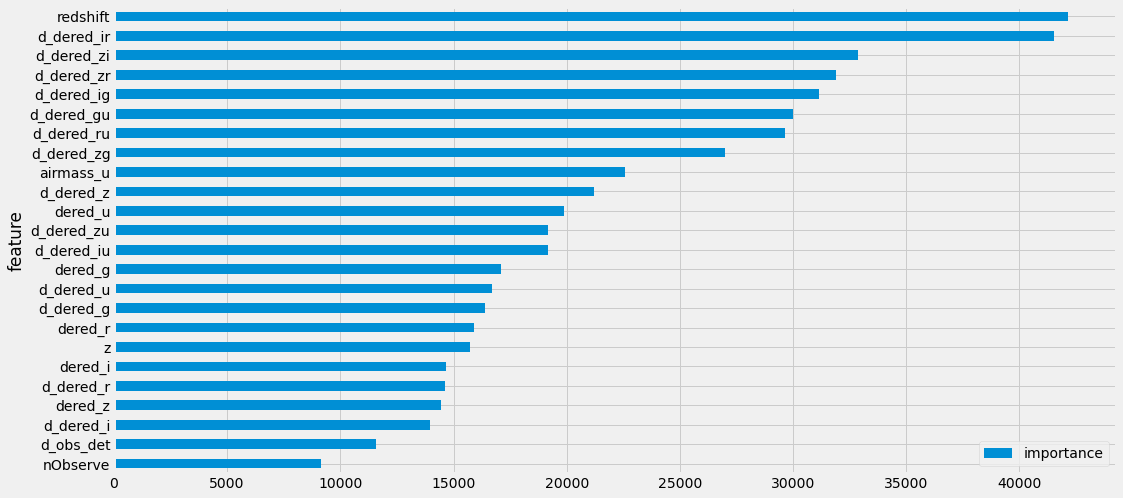

In [39]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [40]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [41]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [42]:
sub[target_col].value_counts()

2    40720
0    29977
1     9303
Name: class, dtype: int64

In [43]:
sub.to_csv(sub_file)